In [1]:
# debugging and formatter
from IPython.core.debugger import set_trace

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
import time
import lightgbm as lgb
import xgboost as xgb

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
from os import listdir
from os.path import isfile, join

loc = os.path.abspath("N:\Kaggle\ieee-fraud-detection")
data_loc = f"{loc}/"

<IPython.core.display.Javascript object>

In [4]:
data_loc

'N:\\Kaggle\\ieee-fraud-detection/'

<IPython.core.display.Javascript object>

In [5]:
%%time
train_id = pd.read_csv(f"{data_loc}/train_identity.csv")
train_tr = pd.read_csv(f"{data_loc}/train_transaction.csv")
test_id = pd.read_csv(f"{data_loc}/test_identity.csv")
test_tr = pd.read_csv(f"{data_loc}/test_transaction.csv")

Wall time: 1min 16s


<IPython.core.display.Javascript object>

In [6]:
print(train_id.info())
print(train_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

<IPython.core.display.Javascript object>

# Downcast types to reduce memory usage

In [7]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df



<IPython.core.display.Javascript object>

In [8]:
train_id = reduce_mem_usage(train_id)
train_tr = reduce_mem_usage(train_tr)
test_id = reduce_mem_usage(test_id)
test_tr = reduce_mem_usage(test_tr)

Initial memory usage of dataframe is 157.63 MB/0.15 GB
Memory usage after optimization is: 10.14 MB/0.01 GB
Decreased by 93.6%
Initial memory usage of dataframe is 2100.70 MB/2.05 GB
Memory usage after optimization is: 487.17 MB/0.48 GB
Decreased by 76.8%
Initial memory usage of dataframe is 154.11 MB/0.15 GB
Memory usage after optimization is: 10.02 MB/0.01 GB
Decreased by 93.5%
Initial memory usage of dataframe is 1807.74 MB/1.77 GB
Memory usage after optimization is: 425.25 MB/0.42 GB
Decreased by 76.5%


<IPython.core.display.Javascript object>

In [9]:
print(train_id.info())
print(train_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   TransactionID  144233 non-null  int32   
 1   id_01          144233 non-null  float16 
 2   id_02          140872 non-null  float32 
 3   id_03          66324 non-null   float16 
 4   id_04          66324 non-null   float16 
 5   id_05          136865 non-null  float16 
 6   id_06          136865 non-null  float16 
 7   id_07          5155 non-null    float16 
 8   id_08          5155 non-null    float16 
 9   id_09          74926 non-null   float16 
 10  id_10          74926 non-null   float16 
 11  id_11          140978 non-null  float16 
 12  id_12          144233 non-null  category
 13  id_13          127320 non-null  float16 
 14  id_14          80044 non-null   float16 
 15  id_15          140985 non-null  category
 16  id_16          129340 non-null  category
 17  id_17     

<IPython.core.display.Javascript object>

In [10]:
train = pd.merge(train_tr, train_id, how="left", on="TransactionID")

<IPython.core.display.Javascript object>

In [329]:
plt.style.use("ggplot")
color_pal = [x["color"] for x in plt.rcParams["axes.prop_cycle"]]

<IPython.core.display.Javascript object>

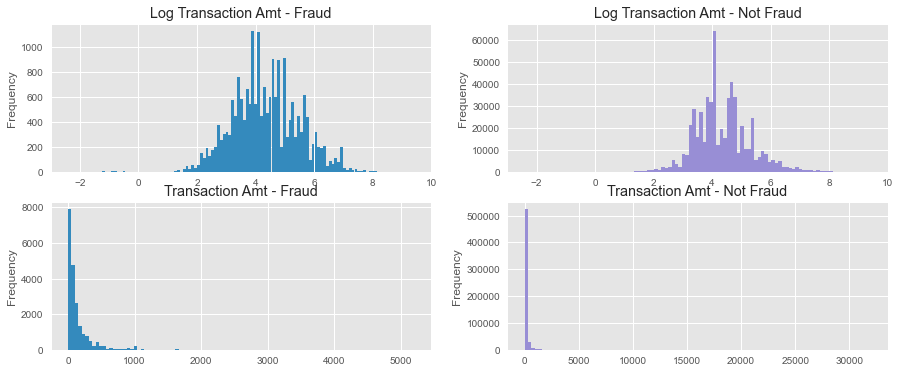

<IPython.core.display.Javascript object>

In [330]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train["isFraud"] == 1]["TransactionAmt"].apply(np.log).plot(
    kind="hist",
    bins=100,
    title="Log Transaction Amt - Fraud",
    color=color_pal[1],
    xlim=(-3, 10),
    ax=ax1,
)
train.loc[train["isFraud"] == 0]["TransactionAmt"].apply(np.log).plot(
    kind="hist",
    bins=100,
    title="Log Transaction Amt - Not Fraud",
    color=color_pal[2],
    xlim=(-3, 10),
    ax=ax2,
)
train.loc[train["isFraud"] == 1]["TransactionAmt"].plot(
    kind="hist", bins=100, title="Transaction Amt - Fraud", color=color_pal[1], ax=ax3
)
train.loc[train["isFraud"] == 0]["TransactionAmt"].plot(
    kind="hist",
    bins=100,
    title="Transaction Amt - Not Fraud",
    color=color_pal[2],
    ax=ax4,
)
plt.show()

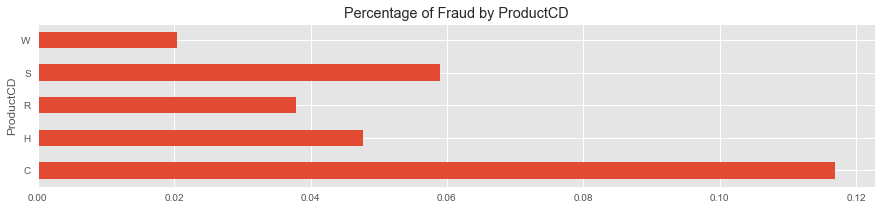

<IPython.core.display.Javascript object>

In [334]:
train.groupby("ProductCD")["isFraud"].mean().sort_index().plot(
    kind="barh", figsize=(15, 3), title="Percentage of Fraud by ProductCD"
)
plt.show()

In [11]:
test = pd.merge(test_tr, test_id, how="left", on="TransactionID")

<IPython.core.display.Javascript object>

In [12]:
test = test.rename(columns=lambda x: "_".join(x.split("-")))

<IPython.core.display.Javascript object>

In [13]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (590540, 434), Test shape: (506691, 433)


<IPython.core.display.Javascript object>

In [14]:
def feature_eng(dataframe, name=True):

    dataframe["hour"] = (dataframe["TransactionDT"] / (3600)) % 24

    def hourFeature(hour):
        if hour > 3 and hour < 12:
            return "highalert"
        if hour > 18 and hour <= 23:
            return "mediumalert"
        else:
            return "lowalert"

    dataframe["alertFeature"] = dataframe["hour"].apply(hourFeature)

    dataframe["LogTransactionAmt"] = np.log(dataframe["TransactionAmt"])

    dataframe["device_name"] = dataframe["DeviceInfo"].str.split("/", expand=True)[0]
    dataframe["device_version"] = dataframe["DeviceInfo"].str.split("/", expand=True)[1]
    if name:
        dataframe["OS_id_30"] = dataframe["id_30"].str.split(" ", expand=True)[0]
        dataframe["version_id_30"] = dataframe["id_30"].str.split(" ", expand=True)[1]

        dataframe["browser_id_31"] = dataframe["id_31"].str.split(" ", expand=True)[0]
        dataframe["version_id_31"] = dataframe["id_31"].str.split(" ", expand=True)[1]

        dataframe["screen_width"] = dataframe["id_33"].str.split("x", expand=True)[0]
        dataframe["screen_height"] = dataframe["id_33"].str.split("x", expand=True)[1]

    dataframe.loc[
        dataframe["device_name"].str.contains("SM", na=False), "device_name"
    ] = "Samsung"
    dataframe.loc[
        dataframe["device_name"].str.contains("SAMSUNG", na=False), "device_name"
    ] = "Samsung"
    dataframe.loc[
        dataframe["device_name"].str.contains("GT-", na=False), "device_name"
    ] = "Samsung"
    dataframe.loc[
        dataframe["device_name"].str.contains("Moto G", na=False), "device_name"
    ] = "Motorola"
    dataframe.loc[
        dataframe["device_name"].str.contains("Moto", na=False), "device_name"
    ] = "Motorola"
    dataframe.loc[
        dataframe["device_name"].str.contains("moto", na=False), "device_name"
    ] = "Motorola"
    dataframe.loc[
        dataframe["device_name"].str.contains("LG-", na=False), "device_name"
    ] = "LG"
    dataframe.loc[
        dataframe["device_name"].str.contains("rv:", na=False), "device_name"
    ] = "RV"
    dataframe.loc[
        dataframe["device_name"].str.contains("HUAWEI", na=False), "device_name"
    ] = "Huawei"
    dataframe.loc[
        dataframe["device_name"].str.contains("ALE-", na=False), "device_name"
    ] = "Huawei"
    dataframe.loc[
        dataframe["device_name"].str.contains("-L", na=False), "device_name"
    ] = "Huawei"
    dataframe.loc[
        dataframe["device_name"].str.contains("Blade", na=False), "device_name"
    ] = "ZTE"
    dataframe.loc[
        dataframe["device_name"].str.contains("BLADE", na=False), "device_name"
    ] = "ZTE"
    dataframe.loc[
        dataframe["device_name"].str.contains("Linux", na=False), "device_name"
    ] = "Linux"
    dataframe.loc[
        dataframe["device_name"].str.contains("XT", na=False), "device_name"
    ] = "Sony"
    dataframe.loc[
        dataframe["device_name"].str.contains("HTC", na=False), "device_name"
    ] = "HTC"
    dataframe.loc[
        dataframe["device_name"].str.contains("ASUS", na=False), "device_name"
    ] = "Asus"

    dataframe.loc[
        dataframe.device_name.isin(
            dataframe.device_name.value_counts()[
                dataframe.device_name.value_counts() < 200
            ].index
        ),
        "device_name",
    ] = "Others"
    dataframe["had_id"] = "1"
    gc.collect()

    dataframe["c2_check"] = dataframe["card2"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["c3_check"] = dataframe["card3"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["new_domain"] = dataframe["P_emaildomain"].apply(
        lambda x: str(x).partition(".")[0]
    )
    dataframe["t_dt_minute"] = dataframe["TransactionDT"] / 60
    dataframe["t_dt_hour"] = dataframe["t_dt_minute"] / 60
    dataframe["t_dt_day"] = dataframe["t_dt_hour"] / 24
    dataframe["t_dt_week"] = dataframe["t_dt_day"] / 7

    # ADD MONTH FEATURE
    START_DATE = datetime.datetime.strptime("2017-11-30", "%Y-%m-%d")
    dataframe["DT_M"] = dataframe["TransactionDT"].map(
        lambda x: (START_DATE + datetime.timedelta(seconds=x))
    )
    dataframe["DT_M"] = (dataframe["DT_M"].dt.year - 2017) * 12 + dataframe[
        "DT_M"
    ].dt.month

    dataframe["card1check"] = dataframe["card1"].apply(
        lambda x: 0 if np.isnan(x) else 1
    )
    dataframe["card2check"] = dataframe["card2"].apply(
        lambda x: 0 if np.isnan(x) else 1
    )

    dataframe["D2_check"] = dataframe["D2"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D3_check"] = dataframe["D3"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D4_check"] = dataframe["D4"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D5_check"] = dataframe["D5"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D6_check"] = dataframe["D6"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D7_check"] = dataframe["D7"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["d8_check"] = dataframe["D8"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D9_check"] = dataframe["D9"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D10_check"] = dataframe["D10"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D11_check"] = dataframe["D11"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D12_check"] = dataframe["D12"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D13_check"] = dataframe["D13"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D14_check"] = dataframe["D14"].apply(lambda x: 0 if np.isnan(x) else 1)
    dataframe["D15_check"] = dataframe["D15"].apply(lambda x: 0 if np.isnan(x) else 1)

    dataframe["new_domain1"] = dataframe["P_emaildomain"].apply(
        lambda x: str(x).partition(".")[-1]
    )
    dataframe["new_domain2"] = dataframe["R_emaildomain"].apply(
        lambda x: str(x).partition(".")[-1]
    )

    dataframe["addr1_addr2"] = dataframe["addr1"] + dataframe["addr2"]
    dataframe["card1_card2"] = dataframe["card1"] + dataframe["card2"]

    dataframe["TransactionAmt_to_mean_card1"] = dataframe[
        "TransactionAmt"
    ] / dataframe.groupby(["card1"])["TransactionAmt"].transform("mean")
    dataframe["TransactionAmt_to_mean_card4"] = dataframe[
        "TransactionAmt"
    ] / dataframe.groupby(["card4"])["TransactionAmt"].transform("mean")
    dataframe["TransactionAmt_to_std_card1"] = dataframe[
        "TransactionAmt"
    ] / dataframe.groupby(["card1"])["TransactionAmt"].transform("std")
    dataframe["TransactionAmt_to_std_card4"] = dataframe[
        "TransactionAmt"
    ] / dataframe.groupby(["card4"])["TransactionAmt"].transform("std")

    dataframe["id_02_to_mean_card1"] = dataframe["id_02"] / dataframe.groupby(
        ["card1"]
    )["id_02"].transform("mean")
    dataframe["id_02_to_mean_card4"] = dataframe["id_02"] / dataframe.groupby(
        ["card4"]
    )["id_02"].transform("mean")
    dataframe["id_02_to_std_card1"] = dataframe["id_02"] / dataframe.groupby(["card1"])[
        "id_02"
    ].transform("std")
    dataframe["id_02_to_std_card4"] = dataframe["id_02"] / dataframe.groupby(["card4"])[
        "id_02"
    ].transform("std")

    dataframe["D15_to_mean_card1"] = dataframe["D15"] / dataframe.groupby(["card1"])[
        "D15"
    ].transform("mean")
    dataframe["D15_to_mean_card4"] = dataframe["D15"] / dataframe.groupby(["card4"])[
        "D15"
    ].transform("mean")
    dataframe["D15_to_std_card1"] = dataframe["D15"] / dataframe.groupby(["card1"])[
        "D15"
    ].transform("std")
    dataframe["D15_to_std_card4"] = dataframe["D15"] / dataframe.groupby(["card4"])[
        "D15"
    ].transform("std")

    dataframe["D15_to_mean_addr1"] = dataframe["D15"] / dataframe.groupby(["addr1"])[
        "D15"
    ].transform("mean")
    dataframe["D15_to_std_addr1"] = dataframe["D15"] / dataframe.groupby(["addr1"])[
        "D15"
    ].transform("std")

    return dataframe

<IPython.core.display.Javascript object>

In [15]:
import gc
import datetime

train = feature_eng(train)
test = feature_eng(test)

<IPython.core.display.Javascript object>

In [16]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (
        dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100
    ).sort_values(ascending=False)
    missing_df = pd.concat(
        [n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"]
    )
    print(missing_df, end="\n")

    if na_name:
        return na_columns, missing_df

<IPython.core.display.Javascript object>

In [17]:
na_cols, train_df = missing_values_table(test, True)
train_df.reset_index(inplace=True)

       n_miss  ratio
id_24  501951  99.06
id_25  501652  99.01
id_26  501644  99.00
id_21  501632  99.00
id_07  501632  99.00
...       ...    ...
V292        3   0.00
V291        3   0.00
V320        3   0.00
C12         3   0.00
C14         3   0.00

[411 rows x 2 columns]


<IPython.core.display.Javascript object>

In [18]:
train_df.head()

,index,n_miss,ratio
0,id_24,501951,99.06
1,id_25,501652,99.01
2,id_26,501644,99.00
3,id_21,501632,99.00
4,id_07,501632,99.00


<IPython.core.display.Javascript object>

In [19]:
na_cols, test_df = missing_values_table(test, True)
test_df.reset_index(inplace=True)

       n_miss  ratio
id_24  501951  99.06
id_25  501652  99.01
id_26  501644  99.00
id_21  501632  99.00
id_07  501632  99.00
...       ...    ...
V292        3   0.00
V291        3   0.00
V320        3   0.00
C12         3   0.00
C14         3   0.00

[411 rows x 2 columns]


<IPython.core.display.Javascript object>

In [20]:
test_df.head()

,index,n_miss,ratio
0,id_24,501951,99.06
1,id_25,501652,99.01
2,id_26,501644,99.00
3,id_21,501632,99.00
4,id_07,501632,99.00


<IPython.core.display.Javascript object>

In [21]:
drop_variables = train_df[train_df["ratio"] > 60]["index"]

<IPython.core.display.Javascript object>

In [22]:
drop_variables.head()

0    id_24
1    id_25
2    id_26
3    id_21
4    id_07
Name: index, dtype: object

<IPython.core.display.Javascript object>

In [335]:
print(drop_variables)

0      id_24
1      id_25
2      id_26
3      id_21
4      id_07
       ...  
217     V239
218     V220
219    id_01
220    id_12
221       M5
Name: index, Length: 222, dtype: object


<IPython.core.display.Javascript object>

In [336]:
train = train.drop(columns=drop_variables)

KeyError: "['id_24' 'id_25' 'id_26' 'id_21' 'id_07' 'id_08' 'id_23' 'id_22' 'id_27'\n 'device_version' 'dist2' 'id_18' 'D7' 'id_03' 'id_04' 'version_id_30'\n 'D12' 'OS_id_30' 'id_30' 'id_32' 'id_33' 'screen_height' 'screen_width'\n 'id_14' 'id_34' 'id_10' 'id_09' 'D8' 'D9' 'V162' 'V163' 'V157' 'V161'\n 'V149' 'V156' 'V155' 'V154' 'V148' 'V158' 'V147' 'V146' 'V142' 'V141'\n 'V140' 'V139' 'V138' 'V153' 'V144' 'V143' 'V152' 'V150' 'V151' 'V145'\n 'V160' 'V164' 'V165' 'V166' 'V159' 'V336' 'V322' 'V338' 'V339' 'V335'\n 'V334' 'V333' 'V332' 'V331' 'V330' 'V337' 'V323' 'V325' 'V329' 'V324'\n 'V328' 'V327' 'V326' 'device_name' 'DeviceInfo' 'D14' 'D13' 'D6' 'id_16'\n 'V257' 'V254' 'V258' 'V252' 'V261' 'V241' 'V253' 'V263' 'V264' 'V260'\n 'V262' 'V249' 'V225' 'V237' 'V236' 'V235' 'V233' 'V232' 'V231' 'V230'\n 'V229' 'V228' 'V226' 'V224' 'V248' 'V223' 'V219' 'V218' 'V217' 'V242'\n 'V266' 'V243' 'V244' 'V246' 'V247' 'V265' 'V240' 'V267' 'V276' 'V269'\n 'V268' 'V273' 'V274' 'V275' 'V278' 'V277' 'id_13' 'id_02_to_std_card1'\n 'id_06' 'id_05' 'version_id_31' 'id_20' 'id_02_to_std_card4'\n 'id_02_to_mean_card4' 'new_domain2' 'R_emaildomain' 'id_19' 'id_17'\n 'V198' 'V197' 'V171' 'V174' 'V175' 'V210' 'V180' 'V184' 'V185' 'V188'\n 'V189' 'V209' 'V208' 'V201' 'V194' 'V169' 'V195' 'V170' 'V200'\n 'browser_id_31' 'id_31' 'V177' 'V179' 'V199' 'V196' 'V176' 'V193' 'V178'\n 'V192' 'V172' 'V181' 'V182' 'V183' 'V191' 'V190' 'V186' 'V173' 'V202'\n 'V203' 'V204' 'V168' 'V167' 'V205' 'V206' 'V207' 'V211' 'V212' 'V213'\n 'V214' 'V215' 'V216' 'V187' 'id_28' 'id_11' 'id_29' 'DeviceType'\n 'id_02_to_mean_card1' 'id_02' 'id_35' 'id_36' 'id_15' 'id_37' 'id_38'\n 'V221' 'V222' 'V251' 'V250' 'V227' 'V255' 'V256' 'V259' 'V234' 'V245'\n 'V272' 'V271' 'V270' 'V238' 'V239' 'V220' 'id_01' 'id_12' 'M5'] not found in axis"

<IPython.core.display.Javascript object>

In [24]:
test = test.drop(columns=drop_variables)

<IPython.core.display.Javascript object>

In [25]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (590540, 266), Test shape: (506691, 265)


<IPython.core.display.Javascript object>

In [26]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.515625,0.377686,0.882898,0.196921,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [27]:
trainNotCategory = train.select_dtypes(include=["number", "bool_", "object_"])
trainCategory = train.select_dtypes(exclude=["number", "bool_", "object_"])

<IPython.core.display.Javascript object>

In [28]:
trainNotCategory.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.515625,0.377686,0.882898,0.196921,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [29]:
trainCategory.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6,M7,M8,M9
0,W,discover,credit,NaN,T,T,T,M2,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [201]:
testNotCategory = test.select_dtypes(include=["number", "bool_", "object_"])
testCategory = test.select_dtypes(exclude=["number", "bool_", "object_"])

<IPython.core.display.Javascript object>

In [31]:
trainNotCategory.fillna(0, inplace=True)
testNotCategory.fillna(0, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<IPython.core.display.Javascript object>

In [32]:
trainNotCategory.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.515625,0.377686,0.882898,0.196921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [33]:
testNotCategory.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,3663549,18403224,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,...,0.339355,0.237305,0.260375,0.129845,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810
1,3663550,18403263,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,...,0.333496,0.364014,0.134278,0.199117,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422
2,3663551,18403310,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,...,1.485352,1.270508,1.895643,0.694877,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657
3,3663552,18403310,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,...,2.970703,2.117188,1.914712,1.158128,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970
4,3663553,18403317,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,...,0.567383,0.517578,0.310075,0.277417,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181


<IPython.core.display.Javascript object>

In [34]:
trainCategory.isna().sum()

ProductCD             0
card4              1577
card6              1571
P_emaildomain     94456
M1               271100
M2               271100
M3               271100
M4               281444
M6               169360
M7               346265
M8               346252
M9               346252
dtype: int64

<IPython.core.display.Javascript object>

In [35]:
testCategory.isna().sum()

ProductCD             0
card4              3086
card6              3007
P_emaildomain     69192
M1               176639
M2               176639
M3               176639
M4               237745
M6               158939
M7               235018
M8               235004
M9               235004
dtype: int64

<IPython.core.display.Javascript object>

In [36]:
trainCategory.columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')

<IPython.core.display.Javascript object>

In [37]:
trainCategory["M1"] = np.where(trainCategory["M1"] == "T", trainCategory["M1"], "M")

<ipython-input-37-c72f63f04615>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["M1"] = np.where(trainCategory["M1"] == "T", trainCategory["M1"], "M")


<IPython.core.display.Javascript object>

In [38]:
trainCategory["M2"] = np.where(trainCategory["M2"] == "T", trainCategory["M2"], "M")
trainCategory["M3"] = np.where(trainCategory["M3"] == "T", trainCategory["M3"], "M")
trainCategory["M4"] = np.where(trainCategory["M4"] == "T", trainCategory["M4"], "M")
trainCategory["M6"] = np.where(trainCategory["M6"] == "T", trainCategory["M6"], "M")
trainCategory["M7"] = np.where(trainCategory["M7"] == "T", trainCategory["M7"], "M")
trainCategory["M8"] = np.where(trainCategory["M8"] == "T", trainCategory["M8"], "M")
trainCategory["M9"] = np.where(trainCategory["M9"] == "T", trainCategory["M9"], "M")

<ipython-input-38-e6d0a6085301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["M2"] = np.where(trainCategory["M2"] == "T", trainCategory["M2"], "M")
<ipython-input-38-e6d0a6085301>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["M3"] = np.where(trainCategory["M3"] == "T", trainCategory["M3"], "M")
<ipython-input-38-e6d0a6085301>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

<IPython.core.display.Javascript object>

In [39]:
trainCategory.nunique()

ProductCD         5
card4             4
card6             4
P_emaildomain    59
M1                2
M2                2
M3                2
M4                1
M6                2
M7                2
M8                2
M9                2
dtype: int64

<IPython.core.display.Javascript object>

In [40]:
trainCategory.isna().sum()

ProductCD            0
card4             1577
card6             1571
P_emaildomain    94456
M1                   0
M2                   0
M3                   0
M4                   0
M6                   0
M7                   0
M8                   0
M9                   0
dtype: int64

<IPython.core.display.Javascript object>

In [41]:
trainCategory["P_emaildomain"] = np.where(
    trainCategory["P_emaildomain"].isna(), "M", trainCategory["P_emaildomain"]
)

<ipython-input-41-0391ffd94a52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["P_emaildomain"] = np.where(


<IPython.core.display.Javascript object>

In [42]:
trainCategory.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6,M7,M8,M9
0,W,discover,credit,M,T,T,T,M,T,M,M,M
1,W,mastercard,credit,gmail.com,M,M,M,M,T,M,M,M
2,W,visa,debit,outlook.com,T,T,T,M,M,M,M,M
3,W,mastercard,debit,yahoo.com,M,M,M,M,M,M,M,M
4,H,mastercard,credit,gmail.com,M,M,M,M,M,M,M,M


<IPython.core.display.Javascript object>

In [43]:
trainCategory["card4"] = np.where(
    trainCategory["card4"].isna(), "M", trainCategory["card4"]
)

trainCategory["card6"] = np.where(
    trainCategory["card6"].isna(), "M", trainCategory["card6"]
)

<ipython-input-43-6adc39eacdb0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["card4"] = np.where(
<ipython-input-43-6adc39eacdb0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory["card6"] = np.where(


<IPython.core.display.Javascript object>

In [44]:
trainCategory.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6,M7,M8,M9
0,W,discover,credit,M,T,T,T,M,T,M,M,M
1,W,mastercard,credit,gmail.com,M,M,M,M,T,M,M,M
2,W,visa,debit,outlook.com,T,T,T,M,M,M,M,M
3,W,mastercard,debit,yahoo.com,M,M,M,M,M,M,M,M
4,H,mastercard,credit,gmail.com,M,M,M,M,M,M,M,M


<IPython.core.display.Javascript object>

In [45]:
trainCategory.isna().sum()

ProductCD        0
card4            0
card6            0
P_emaildomain    0
M1               0
M2               0
M3               0
M4               0
M6               0
M7               0
M8               0
M9               0
dtype: int64

<IPython.core.display.Javascript object>

In [69]:
trainNotCategory.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.515625,0.377686,0.882898,0.196921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [74]:
trainNotCategory.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


<IPython.core.display.Javascript object>

In [130]:
trainNotCategory.isna().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
card1                  0
                    ... 
D15_to_mean_card4      0
D15_to_std_card1     168
D15_to_std_card4       0
D15_to_mean_addr1      0
D15_to_std_addr1       2
Length: 254, dtype: int64

<IPython.core.display.Javascript object>

In [76]:
trainNotCategoryNumber = trainNotCategory.select_dtypes(include=["number"])
trainNotCategoryObject = trainNotCategory.select_dtypes(include=["object_"])

<IPython.core.display.Javascript object>

In [131]:
trainNotCategoryNumber.isna().sum()

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
card1                0
                    ..
D15_to_mean_card4    0
D15_to_std_card1     0
D15_to_std_card4     0
D15_to_mean_addr1    0
D15_to_std_addr1     0
Length: 250, dtype: int64

<IPython.core.display.Javascript object>

In [132]:
trainNotCategoryNumber = trainNotCategoryNumber.fillna(0)

<IPython.core.display.Javascript object>

In [133]:
trainNotCategoryNumber.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,2987000,0,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.515625,0.377686,0.882898,0.196921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [137]:
trainNotCategoryNumber.drop(['TransactionID','TransactionDT'], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [138]:
trainNotCategoryNumber.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,0,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,1.0,...,0.194580,0.257812,0.184560,0.170241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,0.123779,0.219116,0.063004,0.114214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,0.608398,0.443115,0.589226,0.258550,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,0.405029,0.377686,0.259460,0.196921,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,0.515625,0.377686,0.882898,0.196921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [78]:
trainNotCategoryObject.isna().sum()

alertFeature    0
had_id          0
new_domain      0
new_domain1     0
dtype: int64

<IPython.core.display.Javascript object>

In [85]:
from sklearn.preprocessing import LabelEncoder

<IPython.core.display.Javascript object>

In [86]:
le = LabelEncoder()

<IPython.core.display.Javascript object>

In [121]:
trainNotCategoryObject = trainNotCategory.select_dtypes(include=["object_"])

<IPython.core.display.Javascript object>

In [122]:
trainNotCategoryObject.head()

,alertFeature,had_id,new_domain,new_domain1
0,lowalert,1,0,0
1,lowalert,1,gmail,com
2,lowalert,1,outlook,com
3,lowalert,1,yahoo,com
4,lowalert,1,gmail,com


<IPython.core.display.Javascript object>

In [123]:
trainNotCategoryObject.dtypes

alertFeature    object
had_id          object
new_domain      object
new_domain1     object
dtype: object

<IPython.core.display.Javascript object>

In [124]:
trainNotCategoryObject["had_id"] = trainNotCategoryObject.had_id.astype("category")
trainNotCategoryObject["alertFeature"] = trainNotCategoryObject.alertFeature.astype(
    "category"
)
trainNotCategoryObject["new_domain"] = trainNotCategoryObject.new_domain.astype(
    "category"
)
trainNotCategoryObject["new_domain1"] = trainNotCategoryObject.new_domain1.astype(
    "category"
)

<ipython-input-124-fd0096b38c80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNotCategoryObject["had_id"] = trainNotCategoryObject.had_id.astype("category")
<ipython-input-124-fd0096b38c80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNotCategoryObject["alertFeature"] = trainNotCategoryObject.alertFeature.astype(
<ipython-input-124-fd0096b38c80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

<IPython.core.display.Javascript object>

In [125]:
trainNotCategoryObject["new_domain"] = np.where(
    trainNotCategoryObject["new_domain"] == 0, "M", trainNotCategoryObject["new_domain"]
)

<ipython-input-125-22cff511f7d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNotCategoryObject["new_domain"] = np.where(


<IPython.core.display.Javascript object>

In [126]:
trainNotCategoryObject.new_domain.unique()

array(['M', 'gmail', 'outlook', 'yahoo', 'mail', 'anonymous', 'hotmail',
       'verizon', 'aol', 'me', 'comcast', 'optonline', 'cox', 'charter',
       'rocketmail', 'prodigy', 'embarqmail', 'icloud', 'live', 'att',
       'juno', 'ymail', 'sbcglobal', 'bellsouth', 'msn', 'q',
       'centurylink', 'servicios-ta', 'earthlink', 'cfl', 'roadrunner',
       'netzero', 'gmx', 'suddenlink', 'frontiernet', 'windstream',
       'frontier', 'mac', 'aim', 'web', 'twc', 'cableone', 'sc', 'ptd',
       'protonmail'], dtype=object)

<IPython.core.display.Javascript object>

In [127]:
trainNotCategoryObject["new_domain1"] = np.where(
    trainNotCategoryObject["new_domain1"] == 0,
    "M",
    trainNotCategoryObject["new_domain1"],
)

<ipython-input-127-645f0b96e4ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNotCategoryObject["new_domain1"] = np.where(


<IPython.core.display.Javascript object>

In [128]:
for columns in trainNotCategoryObject.columns:
    trainNotCategoryObject[columns] = le.fit_transform(trainNotCategoryObject[columns])

<ipython-input-128-19fb6e993b27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNotCategoryObject[columns] = le.fit_transform(trainNotCategoryObject[columns])


<IPython.core.display.Javascript object>

In [129]:
trainNotCategoryObject.head()

,alertFeature,had_id,new_domain,new_domain1
0,1,0,0,1
1,1,0,16,4
2,1,0,28,4
3,1,0,43,4
4,1,0,16,4


<IPython.core.display.Javascript object>

In [139]:
trainNotCategory = trainNotCategoryNumber.merge(
    trainNotCategoryObject, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [140]:
trainNotCategory.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,alertFeature,had_id,new_domain,new_domain1
0,0,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,1
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,16,4
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,2.519531,1.865234,1.851016,1.541448,1.611328,1.486472,1,0,28,4
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,0.550293,0.720215,0.520531,0.558392,0.686035,0.576638,1,0,43,4
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,16,4


<IPython.core.display.Javascript object>

In [142]:
trainCategory.drop(["P_emaildomain"], axis=1, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<IPython.core.display.Javascript object>

In [144]:
for columns in trainCategory.columns:
    trainCategory[columns] = le.fit_transform(trainCategory[columns])

<ipython-input-144-b445a47672e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainCategory[columns] = le.fit_transform(trainCategory[columns])


<IPython.core.display.Javascript object>

In [145]:
trainCategory.head()

,ProductCD,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,4,2,2,1,1,1,0,1,0,0,0
1,4,3,2,0,0,0,0,1,0,0,0
2,4,4,3,1,1,1,0,0,0,0,0
3,4,3,3,0,0,0,0,0,0,0,0
4,1,3,2,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [146]:
trainDf = trainNotCategory.merge(trainCategory, left_index=True, right_index=True)

<IPython.core.display.Javascript object>

In [147]:
trainDf.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,0,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,1.0,...,2,2,1,1,1,0,1,0,0,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,3,2,0,0,0,0,1,0,0,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,4,3,1,1,1,0,0,0,0,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,3,3,0,0,0,0,0,0,0,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,3,2,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

# Creating Test Data

In [207]:
testCategory.head()

,ProductCD,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,W,visa,debit,T,T,M,M,M,T,T,T
1,W,visa,debit,T,M,M,M,M,M,M,M
2,W,visa,debit,T,T,M,M,M,M,M,M
3,W,visa,debit,T,T,T,M,T,M,M,M
4,W,mastercard,debit,T,T,T,M,M,M,T,T


<IPython.core.display.Javascript object>

In [203]:
testCategory.drop("P_emaildomain", axis=1, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<IPython.core.display.Javascript object>

In [204]:
testCategory["M1"] = np.where(testCategory["M1"] == "T", testCategory["M1"], "M")
testCategory["M2"] = np.where(testCategory["M2"] == "T", testCategory["M2"], "M")
testCategory["M3"] = np.where(testCategory["M3"] == "T", testCategory["M3"], "M")
testCategory["M4"] = np.where(testCategory["M4"] == "T", testCategory["M4"], "M")
testCategory["M6"] = np.where(testCategory["M6"] == "T", testCategory["M6"], "M")
testCategory["M7"] = np.where(testCategory["M7"] == "T", testCategory["M7"], "M")
testCategory["M8"] = np.where(testCategory["M8"] == "T", testCategory["M8"], "M")
testCategory["M9"] = np.where(testCategory["M9"] == "T", testCategory["M9"], "M")

<ipython-input-204-4ee8c5ba8479>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCategory["M1"] = np.where(testCategory["M1"] == "T", testCategory["M1"], "M")
<ipython-input-204-4ee8c5ba8479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCategory["M2"] = np.where(testCategory["M2"] == "T", testCategory["M2"], "M")
<ipython-input-204-4ee8c5ba8479>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


<IPython.core.display.Javascript object>

In [208]:
testCategory["card4"] = np.where(
    testCategory["card4"].isna(), "M", testCategory["card4"]
)

testCategory["card6"] = np.where(
    testCategory["card6"].isna(), "M", testCategory["card6"]
)

<ipython-input-208-8f7eaf1634af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCategory["card4"] = np.where(
<ipython-input-208-8f7eaf1634af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCategory["card6"] = np.where(


<IPython.core.display.Javascript object>

In [209]:
testCategory.isna().sum()

ProductCD    0
card4        0
card6        0
M1           0
M2           0
M3           0
M4           0
M6           0
M7           0
M8           0
M9           0
dtype: int64

<IPython.core.display.Javascript object>

In [210]:
for columns in testCategory.columns:
    testCategory[columns] = le.fit_transform(testCategory[columns])

<ipython-input-210-9748b27717cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCategory[columns] = le.fit_transform(testCategory[columns])


<IPython.core.display.Javascript object>

In [166]:
testNotCategory.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,3663549,18403224,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,...,0.339355,0.237305,0.260375,0.129845,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810
1,3663550,18403263,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,...,0.333496,0.364014,0.134278,0.199117,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422
2,3663551,18403310,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,...,1.485352,1.270508,1.895643,0.694877,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657
3,3663552,18403310,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,...,2.970703,2.117188,1.914712,1.158128,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970
4,3663553,18403317,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,...,0.567383,0.517578,0.310075,0.277417,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181


<IPython.core.display.Javascript object>

In [211]:
TestTransaction = testNotCategory["TransactionID"]

<IPython.core.display.Javascript object>

In [212]:
testNotCategory.drop(["TransactionID", "TransactionDT"], axis=1, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<IPython.core.display.Javascript object>

In [213]:
testNotCategory.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,...,0.339355,0.237305,0.260375,0.129845,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810
1,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,...,0.333496,0.364014,0.134278,0.199117,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422
2,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,...,1.485352,1.270508,1.895643,0.694877,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657
3,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,...,2.970703,2.117188,1.914712,1.158128,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970
4,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,...,0.567383,0.517578,0.310075,0.277417,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181


<IPython.core.display.Javascript object>

In [215]:
testNotCategoryNumber = testNotCategory.select_dtypes(include=["number"])
testNotCategoryObject = testNotCategory.select_dtypes(include=["object_"])

<IPython.core.display.Javascript object>

In [220]:
testNotCategoryNumber.isna().sum()

TransactionAmt       0
card1                0
card2                0
card3                0
card5                0
                    ..
D15_to_mean_card4    0
D15_to_std_card1     0
D15_to_std_card4     0
D15_to_mean_addr1    0
D15_to_std_addr1     0
Length: 247, dtype: int64

<IPython.core.display.Javascript object>

In [222]:
testNotCategoryObject.isna().sum()

alertFeature        0
had_id              0
new_domain      69192
new_domain1     69192
dtype: int64

<IPython.core.display.Javascript object>

In [218]:
testNotCategoryObject.head()

,alertFeature,had_id,new_domain,new_domain1
0,lowalert,1,gmail,com
1,lowalert,1,aol,com
2,lowalert,1,hotmail,com
3,lowalert,1,gmail,com
4,lowalert,1,gmail,com


<IPython.core.display.Javascript object>

In [219]:
testNotCategoryNumber.replace([np.inf, -np.inf], np.nan, inplace=True)
testNotCategoryNumber = testNotCategoryNumber.fillna(0)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


<IPython.core.display.Javascript object>

In [221]:
testNotCategoryNumber.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,...,0.339355,0.237305,0.260375,0.129845,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810
1,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,...,0.333496,0.364014,0.134278,0.199117,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422
2,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,...,1.485352,1.270508,1.895643,0.694877,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657
3,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,...,2.970703,2.117188,1.914712,1.158128,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970
4,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,...,0.567383,0.517578,0.310075,0.277417,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181


<IPython.core.display.Javascript object>

In [226]:
testNotCategoryObject = testNotCategoryObject.fillna(0)

<IPython.core.display.Javascript object>

In [228]:
testNotCategoryObject["new_domain"] = np.where(
    testNotCategoryObject["new_domain"] == 0, "M", testNotCategoryObject["new_domain"]
)

<IPython.core.display.Javascript object>

In [227]:
testNotCategoryObject["new_domain1"] = np.where(
    testNotCategoryObject["new_domain1"] == 0, "M", testNotCategoryObject["new_domain1"]
)

<IPython.core.display.Javascript object>

In [229]:
testNotCategoryObject["had_id"] = testNotCategoryObject.had_id.astype("category")
testNotCategoryObject["alertFeature"] = testNotCategoryObject.alertFeature.astype(
    "category"
)
testNotCategoryObject["new_domain"] = testNotCategoryObject.new_domain.astype(
    "category"
)
testNotCategoryObject["new_domain1"] = testNotCategoryObject.new_domain1.astype(
    "category"
)

<IPython.core.display.Javascript object>

In [230]:
testNotCategoryObject.head()

,alertFeature,had_id,new_domain,new_domain1
0,lowalert,1,gmail,com
1,lowalert,1,aol,com
2,lowalert,1,hotmail,com
3,lowalert,1,gmail,com
4,lowalert,1,gmail,com


<IPython.core.display.Javascript object>

In [231]:
for columns in testNotCategoryObject.columns:
    testNotCategoryObject[columns] = le.fit_transform(testNotCategoryObject[columns])

<IPython.core.display.Javascript object>

In [232]:
testNotCategoryObject.head()

,alertFeature,had_id,new_domain,new_domain1
0,1,0,16,4
1,1,0,3,4
2,1,0,18,4
3,1,0,16,4
4,1,0,16,4


<IPython.core.display.Javascript object>

In [233]:
testNotCategory = testNotCategoryNumber.merge(
    testNotCategoryObject, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [234]:
testNotCategory.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,alertFeature,had_id,new_domain,new_domain1
0,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,...,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810,1,0,16,4
1,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,...,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422,1,0,3,4
2,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,...,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657,1,0,18,4
3,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,...,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970,1,0,16,4
4,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,...,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181,1,0,16,4


<IPython.core.display.Javascript object>

In [235]:
testCategory.head()


,ProductCD,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,4,4,3,1,1,0,0,0,1,1,1
1,4,4,3,1,0,0,0,0,0,0,0
2,4,4,3,1,1,0,0,0,0,0,0
3,4,4,3,1,1,1,0,1,0,0,0
4,4,3,3,1,1,1,0,0,0,1,1


<IPython.core.display.Javascript object>

In [236]:
testDf = testNotCategory.merge(testCategory, left_index=True, right_index=True)

<IPython.core.display.Javascript object>

In [237]:
testDf.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,...,4,3,1,1,0,0,0,1,1,1
1,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,...,4,3,1,0,0,0,0,0,0,0
2,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,...,4,3,1,1,0,0,0,0,0,0
3,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,...,4,3,1,1,1,0,1,0,0,0
4,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,...,3,3,1,1,1,0,0,0,1,1


<IPython.core.display.Javascript object>

In [238]:
trainDf.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,0,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,1.0,...,2,2,1,1,1,0,1,0,0,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,3,2,0,0,0,0,1,0,0,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,4,3,1,1,1,0,0,0,0,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,3,3,0,0,0,0,0,0,0,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,3,2,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [243]:
trainDf.isnull().any()

isFraud           False
TransactionAmt    False
card1             False
card2             False
card3             False
                  ...  
M4                False
M6                False
M7                False
M8                False
M9                False
Length: 263, dtype: bool

<IPython.core.display.Javascript object>

In [246]:
trainDf.isnull().sum().sum()

0

<IPython.core.display.Javascript object>

In [244]:
testDf.isnull().sum().sum()

0

<IPython.core.display.Javascript object>

In [250]:
trainDf.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,0,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,1.0,...,2,2,1,1,1,0,1,0,0,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,3,2,0,0,0,0,1,0,0,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,4,3,1,1,1,0,0,0,0,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,3,3,0,0,0,0,0,0,0,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,3,2,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [251]:
testDf.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,card4,card6,M1,M2,M3,M4,M6,M7,M8,M9
0,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,...,4,3,1,1,0,0,0,1,1,1
1,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,...,4,3,1,0,0,0,0,0,0,0
2,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,...,4,3,1,1,0,0,0,0,0,0
3,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,...,4,3,1,1,1,0,1,0,0,0
4,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,...,3,3,1,1,1,0,0,0,1,1


<IPython.core.display.Javascript object>

# Training the model

In [252]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

<IPython.core.display.Javascript object>

In [253]:
X_train = trainDf.drop(columns=["isFraud"])

<IPython.core.display.Javascript object>

In [254]:
Y_train = trainDf["isFraud"]

<IPython.core.display.Javascript object>

In [255]:
X_test = testDf.copy()

<IPython.core.display.Javascript object>

In [256]:
scaler.fit(X_train)

StandardScaler()

<IPython.core.display.Javascript object>

In [257]:
X_scaled_train = scaler.transform(X_train)

<IPython.core.display.Javascript object>

In [258]:
X_scaled_train

array([[-0.27817409,  0.82169536, -2.19428575, ..., -0.24290026,
        -0.42135533, -0.73098045],
       [-0.4433374 , -1.45755819,  0.28838861, ..., -0.24290026,
        -0.42135533, -0.73098045],
       [-0.31789692, -1.06826307,  0.81687869, ..., -0.24290026,
        -0.42135533, -0.73098045],
       ...,
       [-0.4351707 ,  0.43627687,  1.46212822, ..., -0.24290026,
        -0.42135533, -0.73098045],
       [-0.07537864, -0.42290644,  0.76157159, ..., -0.24290026,
        -0.42135533, -0.73098045],
       [ 0.60618134,  1.05429307, -1.14959604, ..., -0.24290026,
        -0.42135533, -0.73098045]])

<IPython.core.display.Javascript object>

In [261]:
Y_train = trainDf["isFraud"].values

<IPython.core.display.Javascript object>

In [262]:
Y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

<IPython.core.display.Javascript object>

In [268]:
from sklearn.model_selection import cross_val_score

<IPython.core.display.Javascript object>

In [264]:
from sklearn.model_selection import TimeSeriesSplit, KFold

n_folds = 5
folds = TimeSeriesSplit(n_splits=n_folds)
folds = KFold(n_splits=5)

<IPython.core.display.Javascript object>

# XGB

In [263]:
from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [265]:
xgbc = XGBClassifier()
print(xgbc)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, objective='multi:softprob',
              predictor=None, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              tree_method=None, ...)

<IPython.core.display.Javascript object>

In [266]:
xgbc.fit(X_scaled_train, Y_train)

C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [269]:
scores = cross_val_score(xgbc, X_scaled_train, Y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\niraj\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean cross-validation score: 0.82


<IPython.core.display.Javascript object>

In [ ]:
confusion_matrix()

In [322]:
feats = {}
for feature, importance in zip(X_train.columns, xgbc.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient="index").rename(
    columns={0: "Gini-importance"}
)
imp = importances.sort_values(by="Gini-importance", ascending=False)[:20]

<IPython.core.display.Javascript object>

Index(['V91', 'V45', 'V70', 'C7', 'D2_check', 'V103', 'V40', 'C14', 'V308',
       'addr2', 'C1', 'V88', 'V304', 'V318', 'C12', 'V49', 'C4', 'D13_check',
       'V294', 'V317'],
      dtype='object')


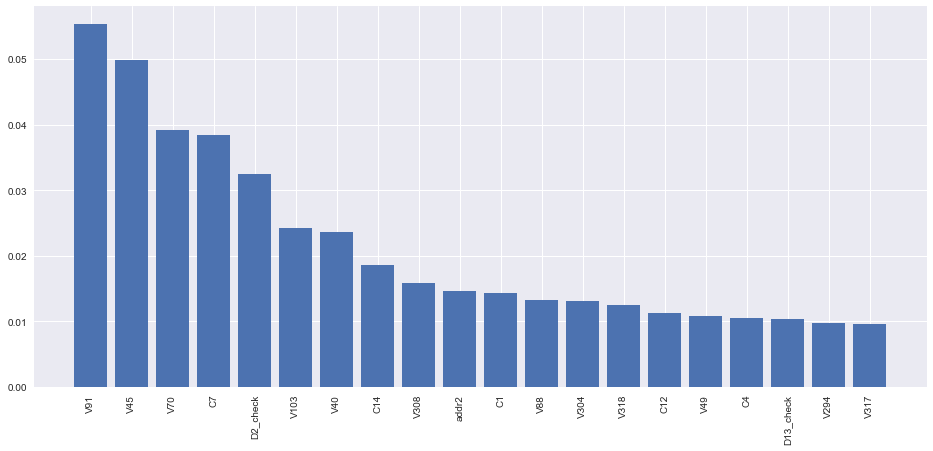

<IPython.core.display.Javascript object>

In [323]:
plt.figure(1, figsize=(16, 7))
plt.bar(imp.index, imp["Gini-importance"])
plt.xticks(imp.index, rotation=90)
print(imp.index)

# LGB

In [270]:
import lightgbm as lgb

<IPython.core.display.Javascript object>

In [274]:
from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [272]:
X_train = trainDf.drop(columns=["isFraud"])
Y_train = trainDf["isFraud"]

<IPython.core.display.Javascript object>

In [271]:
params = {
    "num_leaves": 64,
    "min_child_weight": 0.03,
    "feature_fraction": 0.04,
    "bagging_fraction": 0.33,
    "min_data_in_leaf": 80,
    "objective": "binary",
    "max_depth": -1,
    "learning_rate": 0.006,
    "boosting_type": "gbdt",
    "bagging_seed": 7,
    "metric": "auc",
    "verbosity": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.6,
    "random_state": 0,
}

<IPython.core.display.Javascript object>

In [291]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=42
)

<IPython.core.display.Javascript object>

In [292]:
model = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
model.fit(
    x_train,
    y_train,
    eval_set=[(x_test, y_test), (x_train, y_train)],
    verbose=20,
    eval_metric="logloss",
)

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.094293	valid_0's binary_logloss: 0.0959552
[40]	training's binary_logloss: 0.085312	valid_0's binary_logloss: 0.087678
[60]	training's binary_logloss: 0.0803338	valid_0's binary_logloss: 0.0830723
[80]	training's binary_logloss: 0.0764266	valid_0's binary_logloss: 0.0798267
[100]	training's binary_logloss: 0.0732556	valid_0's binary_logloss: 0.0774504


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

<IPython.core.display.Javascript object>

In [293]:
print("Training accuracy {:.4f}".format(model.score(x_train, y_train)))
print("Testing accuracy {:.4f}".format(model.score(x_test, y_test)))

Training accuracy 0.9783
Testing accuracy 0.9777


<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

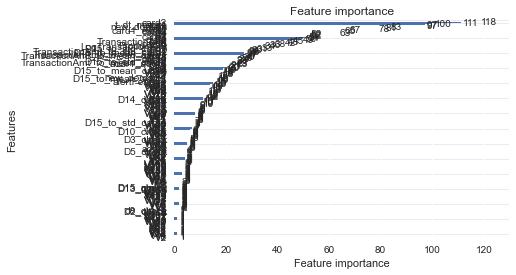

<IPython.core.display.Javascript object>

In [294]:
lgb.plot_importance(model)

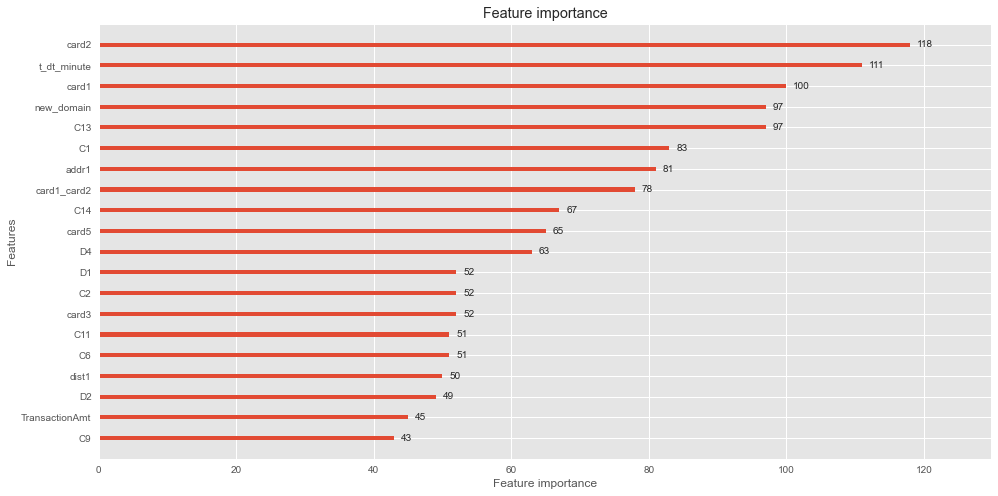

<IPython.core.display.Javascript object>

In [350]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 8)
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

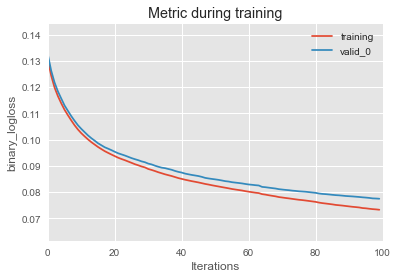

<IPython.core.display.Javascript object>

In [338]:
lgb.plot_metric(model)

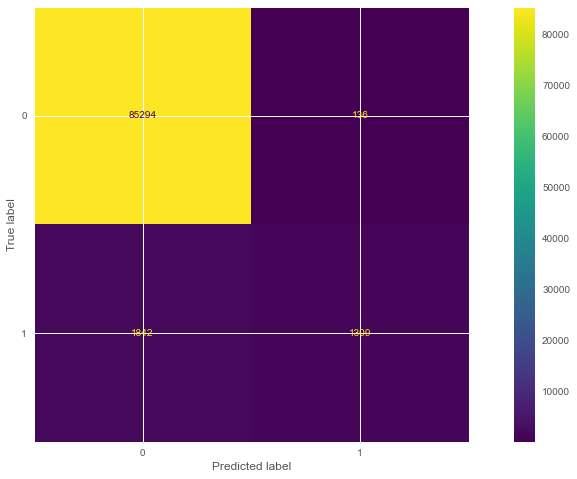

<IPython.core.display.Javascript object>

In [353]:
from sklearn import metrics

metrics.plot_confusion_matrix(model, x_test, y_test)

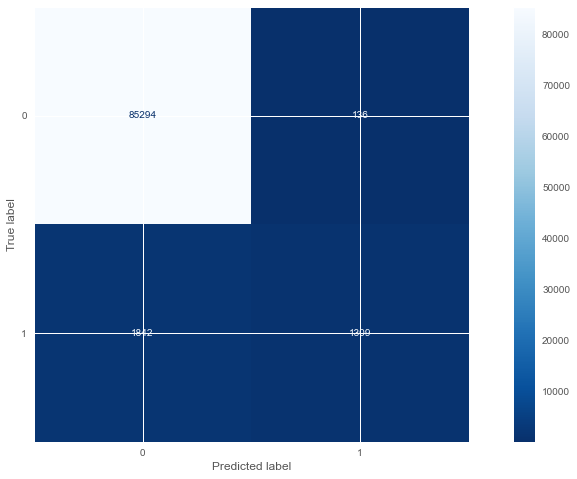

<IPython.core.display.Javascript object>

In [352]:
from sklearn import metrics

metrics.plot_confusion_matrix(model, x_test, y_test, cmap="Blues_r")

In [298]:
print(metrics.classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     85430
           1       0.91      0.42      0.57      3151

    accuracy                           0.98     88581
   macro avg       0.94      0.71      0.78     88581
weighted avg       0.98      0.98      0.97     88581



<IPython.core.display.Javascript object>

# LGB 2

In [299]:
n_folds = 5
folds = TimeSeriesSplit(n_splits=n_folds)
folds = KFold(n_splits=5)

<IPython.core.display.Javascript object>

In [303]:
columns = X_train.columns
y_train = trainDf["isFraud"]

splits = folds.split(X_train, y_train)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score_auc = 0

feature_importances = pd.DataFrame()
feature_importances["feature"] = columns

<IPython.core.display.Javascript object>

In [302]:
gc.collect()

763

<IPython.core.display.Javascript object>

In [304]:
%%time
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_val = clf.predict(X_val)
    y_oof[valid_index] = y_pred_val
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_val, y_pred_val)}")
    
    score_auc += roc_auc_score(y_val, y_pred_val) / n_folds
    
    y_preds += clf.predict(X_test) / n_folds
    
    del X_tr, X_val, y_tr, y_val

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.87348	valid_1's auc: 0.806277
[400]	training's auc: 0.884687	valid_1's auc: 0.820346
[600]	training's auc: 0.894566	valid_1's auc: 0.831636
[800]	training's auc: 0.903822	valid_1's auc: 0.842659
[1000]	training's auc: 0.911497	valid_1's auc: 0.851878
[1200]	training's auc: 0.917507	valid_1's auc: 0.858905
[1400]	training's auc: 0.923312	valid_1's auc: 0.866402
[1600]	training's auc: 0.927953	valid_1's auc: 0.872288
[1800]	training's auc: 0.932278	valid_1's auc: 0.876761
[2000]	training's auc: 0.936173	valid_1's auc: 0.881069
[2200]	training's auc: 0.939656	valid_1's auc: 0.884598
[2400]	training's auc: 0.942523	valid_1's auc: 0.887158
[2600]	training's auc: 0.945125	valid_1's auc: 0.889551
[2800]	training's auc: 0.947529	valid_1's auc: 0.891664
[3000]	training's auc: 0.949818	valid_1's auc: 0.893599
[3200]	training's auc: 0.951898	valid_1's auc: 0.895262
[3400]	training's auc: 0.953686	valid_1's auc: 

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.869699	valid_1's auc: 0.861474
[400]	training's auc: 0.882816	valid_1's auc: 0.869978
[600]	training's auc: 0.893699	valid_1's auc: 0.876319
[800]	training's auc: 0.903441	valid_1's auc: 0.88216
[1000]	training's auc: 0.911151	valid_1's auc: 0.88694
[1200]	training's auc: 0.917124	valid_1's auc: 0.890273
[1400]	training's auc: 0.922881	valid_1's auc: 0.893546
[1600]	training's auc: 0.927616	valid_1's auc: 0.896196
[1800]	training's auc: 0.932088	valid_1's auc: 0.898878
[2000]	training's auc: 0.935893	valid_1's auc: 0.901211
[2200]	training's auc: 0.939379	valid_1's auc: 0.903267
[2400]	training's auc: 0.942209	valid_1's auc: 0.904835
[2600]	training's auc: 0.944789	valid_1's auc: 0.906299
[2800]	training's auc: 0.947115	valid_1's auc: 0.907464
[3000]	training's auc: 0.949297	valid_1's auc: 0.908612
[3200]	training's auc: 0.951347	valid_1's auc: 0.909515
[3400]	training's auc: 0.953157	valid_1's auc: 0

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.870856	valid_1's auc: 0.857398
[400]	training's auc: 0.883898	valid_1's auc: 0.865878
[600]	training's auc: 0.894765	valid_1's auc: 0.872184
[800]	training's auc: 0.904886	valid_1's auc: 0.878272
[1000]	training's auc: 0.912891	valid_1's auc: 0.882922
[1200]	training's auc: 0.918949	valid_1's auc: 0.886152
[1400]	training's auc: 0.924714	valid_1's auc: 0.889773
[1600]	training's auc: 0.929333	valid_1's auc: 0.892218
[1800]	training's auc: 0.933729	valid_1's auc: 0.894734
[2000]	training's auc: 0.93754	valid_1's auc: 0.897041
[2200]	training's auc: 0.941014	valid_1's auc: 0.898942
[2400]	training's auc: 0.943839	valid_1's auc: 0.90048
[2600]	training's auc: 0.946372	valid_1's auc: 0.90185
[2800]	training's auc: 0.948706	valid_1's auc: 0.902992
[3000]	training's auc: 0.950858	valid_1's auc: 0.903885
[3200]	training's auc: 0.952849	valid_1's auc: 0.904645
[3400]	training's auc: 0.954667	valid_1's auc: 0.

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.867093	valid_1's auc: 0.866361
[400]	training's auc: 0.879914	valid_1's auc: 0.876191
[600]	training's auc: 0.890563	valid_1's auc: 0.883705
[800]	training's auc: 0.900826	valid_1's auc: 0.890963
[1000]	training's auc: 0.908879	valid_1's auc: 0.896678
[1200]	training's auc: 0.914948	valid_1's auc: 0.900732
[1400]	training's auc: 0.920961	valid_1's auc: 0.904724
[1600]	training's auc: 0.925675	valid_1's auc: 0.907738
[1800]	training's auc: 0.930162	valid_1's auc: 0.910761
[2000]	training's auc: 0.934074	valid_1's auc: 0.913327
[2200]	training's auc: 0.93757	valid_1's auc: 0.915604
[2400]	training's auc: 0.940452	valid_1's auc: 0.917234
[2600]	training's auc: 0.943114	valid_1's auc: 0.918999
[2800]	training's auc: 0.945549	valid_1's auc: 0.92031
[3000]	training's auc: 0.94781	valid_1's auc: 0.921581
[3200]	training's auc: 0.949869	valid_1's auc: 0.922556
[3400]	training's auc: 0.951721	valid_1's auc: 0.

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.869797	valid_1's auc: 0.849348
[400]	training's auc: 0.88253	valid_1's auc: 0.857045
[600]	training's auc: 0.893603	valid_1's auc: 0.864231
[800]	training's auc: 0.903942	valid_1's auc: 0.870872
[1000]	training's auc: 0.912416	valid_1's auc: 0.876376
[1200]	training's auc: 0.91852	valid_1's auc: 0.880165
[1400]	training's auc: 0.924473	valid_1's auc: 0.884107
[1600]	training's auc: 0.929034	valid_1's auc: 0.88665
[1800]	training's auc: 0.933328	valid_1's auc: 0.889374
[2000]	training's auc: 0.937078	valid_1's auc: 0.891878
[2200]	training's auc: 0.94055	valid_1's auc: 0.894136
[2400]	training's auc: 0.943247	valid_1's auc: 0.895869
[2600]	training's auc: 0.945745	valid_1's auc: 0.897409
[2800]	training's auc: 0.948036	valid_1's auc: 0.898538
[3000]	training's auc: 0.950226	valid_1's auc: 0.899661
[3200]	training's auc: 0.95226	valid_1's auc: 0.900658
[3400]	training's auc: 0.953998	valid_1's auc: 0.90

<IPython.core.display.Javascript object>

In [305]:
print(f"\nMean AUC = {score_auc}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")


Mean AUC = 0.9178157507936816
Out of folds AUC = 0.9174568617920863


<IPython.core.display.Javascript object>

In [306]:
feature_importances["average"] = feature_importances[
    ["fold_{}".format(fold + 1) for fold in range(folds.n_splits)]
].mean(axis=1)

<IPython.core.display.Javascript object>

In [307]:
f = (
    feature_importances[["feature", "average"]]
    .sort_values(by="average", ascending=False)
    .head(20)
)

<IPython.core.display.Javascript object>

Index(['V91', 'V45', 'V70', 'C7', 'D2_check', 'V103', 'V40', 'C14', 'V308',
       'addr2', 'C1', 'V88', 'V304', 'V318', 'C12', 'V49', 'C4', 'D13_check',
       'V294', 'V317'],
      dtype='object')


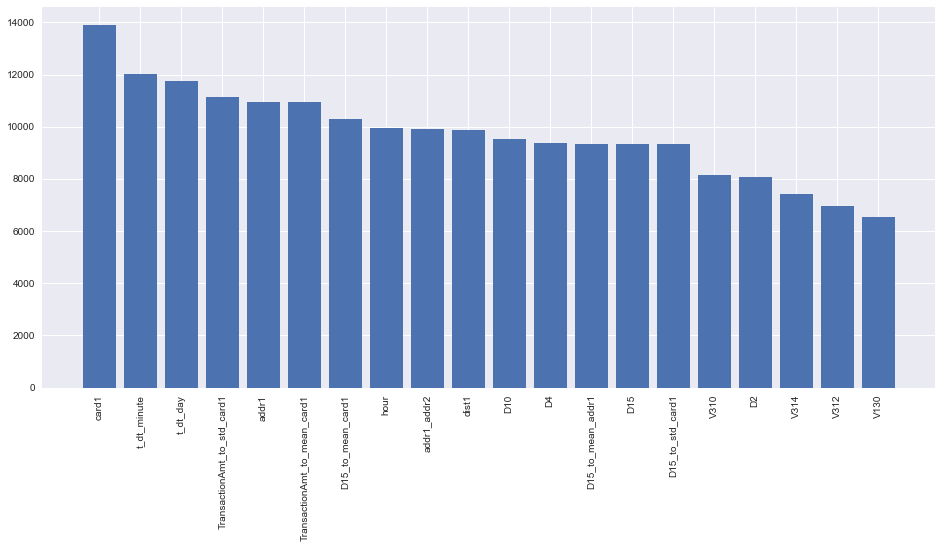

<IPython.core.display.Javascript object>

In [324]:
plt.figure(1, figsize=(16, 7))
plt.bar(f["feature"], f["average"])
plt.xticks(f["feature"], rotation=90)
print(imp.index)

In [316]:
important = {
    "boosting_type": "gbdt",
    "class_weight": None,
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.006,
    "max_depth": -1,
    "min_child_samples": 20,
    "min_child_weight": 0.03,
    "min_split_gain": 0.0,
    "n_estimators": 100,
    "n_jobs": -1,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 0,
    "reg_alpha": 0.3,
    "reg_lambda": 0.6,
    "silent": True,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0,
    "feature_fraction": 0.04,
    "bagging_fraction": 0.33,
    "min_data_in_leaf": 80,
    "bagging_seed": 7,
    "metric": "auc",
    "verbosity": -1,
    "num_boost_round": 5575,
}

<IPython.core.display.Javascript object>

In [309]:
sub = pd.read_csv(f"{data_loc}/sample_submission.csv")

<IPython.core.display.Javascript object>

In [310]:
sub

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


<IPython.core.display.Javascript object>

In [317]:
final_clf = lgb.LGBMClassifier(**important)

<IPython.core.display.Javascript object>

In [318]:
final_clf.fit(X_train, y_train)

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.04, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_fraction is set=0.33, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33
[LightGBM] [Warning] num_iterations is set=5575, num_boost_round=5575 will be ignored. Current value: num_iterations=5575


LGBMClassifier(bagging_fraction=0.33, bagging_seed=7, feature_fraction=0.04,
               learning_rate=0.006, metric='auc', min_child_weight=0.03,
               min_data_in_leaf=80, num_boost_round=5575, num_leaves=64,
               objective='binary', random_state=0, reg_alpha=0.3,
               reg_lambda=0.6, silent=True, verbosity=-1)

<IPython.core.display.Javascript object>

In [319]:
sub["Fraud"] = final_clf.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

In [320]:
sub.drop("isFraud", axis=1).rename(columns={"Fraud": "isFraud"}).to_csv(
    f"{data_loc}/final_submission.csv", index=False
)

<IPython.core.display.Javascript object>

In [321]:
sub

,TransactionID,isFraud,Fraud
0,3663549,0.5,0.005872
1,3663550,0.5,0.008845
2,3663551,0.5,0.015469
3,3663552,0.5,0.002775
4,3663553,0.5,0.004924
...,...,...,...
506686,4170235,0.5,0.022617
506687,4170236,0.5,0.024667
506688,4170237,0.5,0.009430
506689,4170238,0.5,0.013052


<IPython.core.display.Javascript object>

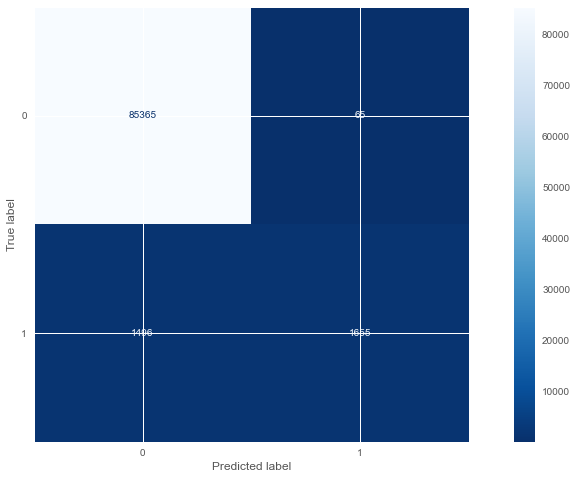

<IPython.core.display.Javascript object>

In [354]:
from sklearn import metrics

metrics.plot_confusion_matrix(final_clf, y_val, y_pred_val, cmap="Blues_r")

In [355]:
metrics.plot_confusion_matrix(final_clf, y_val, y_pred_val, cmap="Blues_r")

NameError: name 'y_val' is not defined

<IPython.core.display.Javascript object>

In [289]:
# prediction
y_pred = model.predict(x_test)

<IPython.core.display.Javascript object>

In [290]:
y_pred

array([0.03097634, 0.02558138, 0.0243782 , ..., 0.02446462, 0.02621964,
       0.02634552])

<IPython.core.display.Javascript object>

In [281]:
from numpy import argmax
from sklearn.metrics import classification_report

<IPython.core.display.Javascript object>

In [286]:
y_pred = model.predict(x_test)
y_pred = argmax(y_pred, axis=0)

<IPython.core.display.Javascript object>

In [288]:
y_pred

29822

<IPython.core.display.Javascript object>

In [287]:
cr = classification_report(y_test, y_pred)


TypeError: Singleton array 29822 cannot be considered a valid collection.

<IPython.core.display.Javascript object>

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

In [62]:
columns = X_train.columns

splits = folds.split(X_train, Y_train)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score_auc = 0

feature_importances = pd.DataFrame()
feature_importances["feature"] = columns

<IPython.core.display.Javascript object>

In [64]:
params = {
    "num_leaves": 64,
    "min_child_weight": 0.03,
    "feature_fraction": 0.04,
    "bagging_fraction": 0.33,
    "min_data_in_leaf": 80,
    "objective": "binary",
    "max_depth": -1,
    "learning_rate": 0.006,
    "boosting_type": "gbdt",
    "bagging_seed": 7,
    "metric": "auc",
    "verbosity": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.6,
    "random_state": 0,
}

<IPython.core.display.Javascript object>

In [65]:
%%time
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = Y_train.iloc[train_index], Y_train.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_val = clf.predict(X_val)
    y_oof[valid_index] = y_pred_val
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_val, y_pred_val)}")
    
    score_auc += roc_auc_score(y_val, y_pred_val) / n_folds
    
    y_preds += clf.predict(X_test) / n_folds
    
    del X_tr, X_val, y_tr, y_val

C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\niraj\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: alertFeature, had_id, new_domain, new_domain1, card4, card6, P_emaildomain, M1, M2, M3, M4, M6, M7, M8, M9

<IPython.core.display.Javascript object>

In [67]:
# Useless from EDA

train.drop(["M1", "id_27", "V1", "V14", "V41", "V68", "V305"], axis = 1 , inplace=True)
test.drop(["M1", "id_27", "V1", "V14", "V41", "V68", "V305"], axis=1 , inplace=True)


KeyError: "['M1' 'id_27' 'V1' 'V14' 'V41' 'V68' 'V305'] not found in axis"

<IPython.core.display.Javascript object>

In [80]:
drop_variables = train_df[train_df["ratio"] > 60]["index"]

<IPython.core.display.Javascript object>

In [81]:
drop_variables.head()

0    id_24
1    id_25
2    id_26
3    id_08
4    id_07
Name: index, dtype: object

<IPython.core.display.Javascript object>

In [82]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

<IPython.core.display.Javascript object>

In [88]:
import gc
import datetime
train = feature_eng(train)
test = feature_eng(test)

<IPython.core.display.Javascript object>

In [89]:
train = feature_eng(train)
test = feature_eng(test)

<IPython.core.display.Javascript object>

In [92]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,1.065430,1.925781,1.665603,1.502141,1.557617,1.450810
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,2.154297,2.984375,2.047675,2.328502,3.033203,2.300422
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,0.280029,0.456787,0.339451,0.356253,0.457031,0.351657
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,1.579102,1.139648,1.130023,0.888797,1.020508,0.901970
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,0.085876,0.109680,0.075361,0.083425,0.098999,0.080181


<IPython.core.display.Javascript object>

In [97]:
train.DeviceType

0            NaN
1            NaN
2            NaN
3            NaN
4         mobile
           ...  
590535       NaN
590536       NaN
590537       NaN
590538       NaN
590539       NaN
Name: DeviceType, Length: 590540, dtype: category
Categories (2, object): ['desktop', 'mobile']

<IPython.core.display.Javascript object>

In [100]:
# missing values
train = clean_inf_nan(train)
test =  clean_inf_nan(test)


<IPython.core.display.Javascript object>

In [98]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

<IPython.core.display.Javascript object>

In [103]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (590540, 481), Test shape: (506691, 482)


<IPython.core.display.Javascript object>

In [104]:
train.select_dtypes(exclude=["number","bool_","object_"])


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M2,M3,M4,M5,M6,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,M2,F,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,M0,F,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,T,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,NaN,NaN,T,T,M0,T,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,W,mastercard,debit,gmail.com,NaN,F,F,M0,F,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,W,mastercard,debit,gmail.com,NaN,F,F,NaN,NaN,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,W,mastercard,debit,aol.com,NaN,T,T,M0,F,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [101]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

<IPython.core.display.Javascript object>

In [106]:
imp_features = [
    "TransactionAmt",
    "ProductCD",
    "card1",
    "card2",
    "card3",
    "card5",
    "card6",
    "addr1",
    "addr2",
    "dist1",
    "dist2",
    "P_emaildomain",
    "R_emaildomain",
    "C1",
    "C2",
    "C4",
    "C5",
    "C6",
    "C7",
    "C8",
    "C9",
    "C10",
    "C11",
    "C12",
    "C13",
    "C14",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "D10",
    "D11",
    "D15",
    "M1",
    "M2",
    "M3",
    "M4",
    "M6",
    "M7",
    "M8",
    "M9",
    "V1",
    "V3",
    "V4",
    "V6",
    "V8",
    "V11",
    "V13",
    "V14",
    "V17",
    "V20",
    "V23",
    "V26",
    "V27",
    "V30",
    "V36",
    "V37",
    "V40",
    "V41",
    "V44",
    "V47",
    "V48",
    "V54",
    "V56",
    "V59",
    "V62",
    "V65",
    "V67",
    "V68",
    "V70",
    "V76",
    "V78",
    "V80",
    "V82",
    "V86",
    "V88",
    "V89",
    "V91",
    "V107",
    "V108",
    "V111",
    "V115",
    "V117",
    "V120",
    "V121",
    "V123",
    "V124",
    "V127",
    "V129",
    "V130",
    "V136",
    "V138",
    "V139",
    "V142",
    "V147",
    "V156",
    "V160",
    "V162",
    "V165",
    "V166",
    "V169",
    "V171",
    "V173",
    "V175",
    "V176",
    "V178",
    "V180",
    "V182",
    "V185",
    "V187",
    "V188",
    "V198",
    "V203",
    "V205",
    "V207",
    "V209",
    "V210",
    "V215",
    "V218",
    "V220",
    "V221",
    "V223",
    "V224",
    "V226",
    "V228",
    "V229",
    "V234",
    "V235",
    "V238",
    "V240",
    "V250",
    "V252",
    "V253",
    "V257",
    "V258",
    "V260",
    "V261",
    "V264",
    "V266",
    "V267",
    "V271",
    "V274",
    "V277",
    "V281",
    "V283",
    "V284",
    "V285",
    "V286",
    "V289",
    "V291",
    "V294",
    "V296",
    "V297",
    "V301",
    "V303",
    "V305",
    "V307",
    "V309",
    "V310",
    "V314",
    "V320",
    "DeviceType",
    "DeviceInfo",
    "isFraud",
]

<IPython.core.display.Javascript object>

In [107]:
len(imp_features)

165

<IPython.core.display.Javascript object>

In [108]:
cols_to_drop_train = [col for col in train.columns if col not in imp_features]
cols_to_drop_test = [col for col in test.columns if col not in imp_features]

print(f"{len(cols_to_drop_train)} features from train are going to be dropped.")
print(f"{len(cols_to_drop_test)} features from test are going to be dropped.")

322 features from train are going to be dropped.
323 features from test are going to be dropped.


<IPython.core.display.Javascript object>

In [109]:
trainnew = train.drop(cols_to_drop_train, axis=1)
testnew = test.drop(cols_to_drop_test, axis=1)

<IPython.core.display.Javascript object>

In [110]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

<IPython.core.display.Javascript object>

In [111]:
trainnew = clean_inf_nan(trainnew)
testnew = clean_inf_nan(testnew)

<IPython.core.display.Javascript object>

In [112]:
trainnew.head(2)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,...,V297,V301,V303,V307,V309,V310,V314,V320,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,142.0,credit,315.0,87.0,...,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,102.0,credit,325.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


<IPython.core.display.Javascript object>

In [116]:
trainnew.select_dtypes(exclude=["number","bool_","object_"])


,ProductCD,card6,P_emaildomain,R_emaildomain,M2,M3,M4,M6,M7,M8,M9,DeviceType,DeviceInfo
0,W,credit,NaN,NaN,T,T,M2,T,NaN,NaN,NaN,NaN,NaN
1,W,credit,gmail.com,NaN,NaN,NaN,M0,T,NaN,NaN,NaN,NaN,NaN
2,W,debit,outlook.com,NaN,T,T,M0,F,F,F,F,NaN,NaN
3,W,debit,yahoo.com,NaN,NaN,NaN,M0,F,NaN,NaN,NaN,NaN,NaN
4,H,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,debit,NaN,NaN,T,T,M0,F,F,F,T,NaN,NaN
590536,W,debit,gmail.com,NaN,F,F,M0,T,F,F,F,NaN,NaN
590537,W,debit,gmail.com,NaN,F,F,NaN,T,NaN,NaN,NaN,NaN,NaN
590538,W,debit,aol.com,NaN,T,T,M0,T,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [115]:
print(f"Train shape: {trainnew.shape}, Test shape: {testnew.shape}")

Train shape: (590540, 159), Test shape: (506691, 159)


<IPython.core.display.Javascript object>

In [123]:
traindf = trainnew.select_dtypes(include=["number", "bool_", "object_"])

<IPython.core.display.Javascript object>

In [124]:
traindf.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V294,V296,V297,V301,V303,V307,V309,V310,V314,V320
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,...,38.0,0.0,0.0,0.0,0.0,1758.0,0.0,354.0,0.0,0.0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [125]:
traindf.fillna(0, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<IPython.core.display.Javascript object>

In [1]:
traindf.head()

NameError: name 'traindf' is not defined

In [127]:
testdf = testnew.select_dtypes(include=["number", "bool_", "object_"])

<IPython.core.display.Javascript object>

In [128]:
testdf.fillna(0, inplace=True)

C:\Users\niraj\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<IPython.core.display.Javascript object>

In [129]:
testCatDf = testnew.select_dtypes(exclude=["number", "bool_", "object_"])
trainCatDf = trainnew.select_dtypes(exclude=["number", "bool_", "object_"])

<IPython.core.display.Javascript object>

In [130]:
testCatDf.head()

,ProductCD,card6,P_emaildomain,R_emaildomain,M2,M3,M4,M6,M7,M8,M9,DeviceType,DeviceInfo
0,W,debit,gmail.com,NaN,T,F,NaN,F,T,T,T,NaN,NaN
1,W,debit,aol.com,NaN,F,F,M0,F,NaN,NaN,NaN,NaN,NaN
2,W,debit,hotmail.com,NaN,T,F,M0,F,F,F,F,NaN,NaN
3,W,debit,gmail.com,NaN,T,T,NaN,T,NaN,NaN,NaN,NaN,NaN
4,W,debit,gmail.com,NaN,T,T,NaN,F,F,T,T,NaN,NaN


<IPython.core.display.Javascript object>

In [131]:
trainCatDf.head()

,ProductCD,card6,P_emaildomain,R_emaildomain,M2,M3,M4,M6,M7,M8,M9,DeviceType,DeviceInfo
0,W,credit,NaN,NaN,T,T,M2,T,NaN,NaN,NaN,NaN,NaN
1,W,credit,gmail.com,NaN,NaN,NaN,M0,T,NaN,NaN,NaN,NaN,NaN
2,W,debit,outlook.com,NaN,T,T,M0,F,F,F,F,NaN,NaN
3,W,debit,yahoo.com,NaN,NaN,NaN,M0,F,NaN,NaN,NaN,NaN,NaN
4,H,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


<IPython.core.display.Javascript object>

In [138]:
trainCatDf.isna().sum()

ProductCD             0
card6              1571
P_emaildomain     94456
R_emaildomain    453249
M2               271100
M3               271100
M4               281444
M6               169360
M7               346265
M8               346252
M9               346252
DeviceType       449730
DeviceInfo       471874
dtype: int64

<IPython.core.display.Javascript object>

In [141]:
trainCatDf.nunique()

ProductCD           5
card6               4
P_emaildomain      59
R_emaildomain      60
M2                  2
M3                  2
M4                  3
M6                  2
M7                  2
M8                  2
M9                  2
DeviceType          2
DeviceInfo       1786
dtype: int64

<IPython.core.display.Javascript object>

In [142]:
train.nunique()

TransactionID        590540
isFraud                   2
TransactionDT        573349
TransactionAmt         8195
ProductCD                 5
                      ...  
D15_to_mean_card4      1966
D15_to_std_card1     174889
D15_to_std_card4       2581
D15_to_mean_addr1      5999
D15_to_std_addr1      31471
Length: 481, dtype: int64

<IPython.core.display.Javascript object>

In [136]:
trainCatDf.shape

(590540, 13)

<IPython.core.display.Javascript object>

In [132]:
y_train = trainCatDf.isFraud.values

AttributeError: 'DataFrame' object has no attribute 'isFraud'

<IPython.core.display.Javascript object>

In [ ]:
def eva_cat_feature(feature):
    
    #Removing missing 
    sel = ~trainCatDf.loc[:,feature].isna().values
    column = trainCatDf.loc[:,[feature]].dropna().astype('str')
    y_temp = y_train[sel]
    
    